In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import imutils
from imutils import paths
from imutils.object_detection import non_max_suppression
import math

In [3]:
def find_top(img):
    height= img.shape[0]
    width =img.shape[1]
    for y in range(height):
        line = np.asarray(img[y,:])            
        line_xs = np.nonzero(line)[0]
        if np.any(line_xs):
            for x in line_xs:
                if x > 20:
                    shape_top_y = y
                    top_mid_x = x
                    return shape_top_y, top_mid_x  
    return shape_top_y, top_mid_x

def fillHole( im_in, im_out):
    th, im_th = cv2.threshold(im_in, 220, 255, cv2.THRESH_BINARY_INV);
    # Copy the thresholded image.
    im_floodfill = im_th.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    
    start_point = find_top(im_in)
    
    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (start_point[1],start_point[0]), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv

In [4]:
#== Processing =======================================================================
def find_edges(img,pose):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
#     cv2.imwrite(outputPath + 'shape_' + image_name, img)    
    y_start = int(img.shape[0] * 0.19)
    y_stop = img.shape[0]
    x_start = int(img.shape[1] * 0.4)
    x_stop = int(img.shape[1] * 0.75)
    img = img[y_start:y_stop,x_start:x_stop,:]    
    
    img = cv2.resize(img, (0,0), fx=0.5, fy=0.5) # reduce size to save computation cost
#     print(img.shape)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,100,255,cv2.THRESH_BINARY)
    
   #-- Edge detection -------------------------------------------------------------------
    blur = cv2.GaussianBlur(gray,(3,3),0)    
    v = np.median(blur)
    SIGMA = 0.33
    lower = int(max(0, (1.0 - SIGMA) * v))
    upper = int(min(255, (1.0 + SIGMA) * v))
    edges = cv2.Canny(blur, lower, upper)
    
    ret,edges = cv2.threshold(edges,100,255,cv2.THRESH_BINARY)
    
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2));
#     for i in range(1):
#         edges = cv2.dilate(edges,kernel,iterations = 1)        
    for i in range(3):
        fillHole(edges,edges)
#     thresh, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
    # ------------------ detect lines ---------------------------------------------
    shape_top_y, top_mid_x = find_top(edges)
    most_left_line_points = np.zeros(4,dtype=int)    
    lines = cv2.HoughLinesP(edges,rho = 1,theta = 1*np.pi/180,threshold = 5,minLineLength = 50,maxLineGap = 20)
    if lines is not None:
        nr_lines = len(lines)
        most_left_x = edges.shape[1]

        for i in range(0, nr_lines):
            for x1,y1,x2,y2 in lines[i]:
                left_x = min(x1,x2)    
#                 right_x = max(x1,x2)  
                if (x1+x2)/2 > top_mid_x or (y1+y2)/2 < (edges.shape[0]-shape_top_y)/2 + shape_top_y:
                    continue                
#                 cv2.line(edges,(x1,y1),(x2,y2),(255,255,0),10)
                myradians = math.atan2(y2-y1, x2-x1)
                mydegrees = math.degrees(myradians)                
#                 print('degree=',mydegrees)
                if abs(mydegrees) > 50 and abs(mydegrees) < 75:           
                    if left_x < most_left_x :
                        most_left_x = left_x
                        most_left_line_points[0] = x1
                        most_left_line_points[1] = y1
                        most_left_line_points[2] = x2
                        most_left_line_points[3] = y2

        cv2.line(edges,(most_left_line_points[0],most_left_line_points[1]),(most_left_line_points[2],most_left_line_points[3]),(255,255,0),5)

    
    #----------------------remove trendmill base----------------------------
    height, width = edges.shape
#     edges[int(height*0.36):height,0:int(width*0.26)] = 0
    edges[int(height*14/15):height,0:width] = 0   # base
#     edges[int(height*14/15),0:width] = 255   # draw a base line
    
    trendmill_right_x = max(most_left_line_points[0],most_left_line_points[2])
    edges[int(height/2):height,0:trendmill_right_x] = 0     

    return edges,trendmill_right_x


In [5]:
# load shape image and compute measurements
# shapeImages = list(paths.list_images(shapePath))
NUM_PERSON = 44
NUM_BODY_FEATURE = 6+10 # height, head_width, neck_width, shoulder_width, waist_width, ankle width, 
training_shape_specs = np.zeros((NUM_PERSON*2,NUM_BODY_FEATURE))

person_list = []
person_id = np.zeros(NUM_PERSON*2)


def find_waist_width(img,pose,top_y,top_mid_x,neck_left,neck_right,shoulder_left,shoulder_right,trendmill_right_x):
    height, width = img.shape
    waist_y = int((height-top_y)/2) + top_y
    waist_left_x = 0 
    waist_right_x = 0
    line = np.asarray(img[waist_y,:]) 
    line_xs = np.nonzero(line)
    if np.any(line_xs):        
        left_line = np.asarray(img[waist_y,0:top_mid_x])    
        
        waist_left = np.nonzero(left_line)[0]
        if np.any(waist_left):
            waist_left_x = waist_left[-1] 
        else:
            waist_left = top_mid_x
        right_line = np.asarray(img[waist_y,top_mid_x:width])  
        
        waist_right = np.nonzero(right_line)[0]
        if np.any(waist_right):
            waist_right_x = top_mid_x+ waist_right[-1]          

        if waist_left_x > neck_left or waist_right_x < neck_right or waist_left_x < neck_left - (neck_right-neck_left):
            waist_left_x = shoulder_left
            waist_right_x = shoulder_right    
    return  waist_y,waist_left_x, waist_right_x

def find_neck_head_width(img,pose,shape_top_y):
    height, width = img.shape
    head_width = 0
    head_left_edge = 0
    head_right_edge = 0
    search_scope = 60 # pixels = 4 * 15 cm
    
    width_array = np.zeros((search_scope,3))
#     print('width_array  shape = ', width_array.shape)     

    for y in range(shape_top_y, shape_top_y+search_scope,1):
        horizon_line = np.asarray(img[y,:])        
        horizon_line_x = np.nonzero(horizon_line)[0]
        if np.any(horizon_line_x) == False:
            continue
        left = horizon_line_x[0]
        right = horizon_line_x[-1]
        offset = y - shape_top_y
        width_shape = right - left
        width_array[offset, 0] = width_shape
        width_array[offset, 1] = left
        width_array[offset, 2] = right   
    max_width_offset = np.argmax(width_array,axis=0)[0]     
    head_left = int(width_array[max_width_offset,1])
    head_right =int(width_array[max_width_offset,2])
    head_y = shape_top_y + max_width_offset       
    
    search_scope = 80 # pixels = 4 * 20 cm
    width_array = np.zeros((search_scope,3))
#     print('width_array  shape = ', width_array.shape)   
    for y in range(head_y,head_y + search_scope,1):  
        horizon_line = np.asarray(img[y,:])        
        horizon_line_x = np.nonzero(horizon_line)[0]
        if np.any(horizon_line_x) == False:
            continue
        left = horizon_line_x[0]
        right = horizon_line_x[-1]
        offset = y - head_y
        width_shape = right - left
        if width_shape < 40:
            width_shape = 100
        width_array[offset, 0] = width_shape
        width_array[offset, 1] = left
        width_array[offset, 2] = right       
    min_width_offset = np.argmin(width_array,axis=0)[0]     
    neck_left = int(width_array[min_width_offset,1])
    neck_right = int(width_array[min_width_offset,2])
    neck_y = head_y + min_width_offset  
        
    return neck_y, neck_left,neck_right,head_y,head_left,head_right

def find_shoulder_width(img,pose,top_mid_x,neck_width,neck_y):
    height, width = img.shape
    shoulder_y = neck_y + 10* 4 # 10 cm below neck        
    shoulder_left_x = 0 
    shoulder_right_x = 0
    line = np.asarray(img[shoulder_y,:]) 
    line_xs = np.nonzero(line)
    if np.any(line_xs):        
        left_line = np.asarray(img[shoulder_y,0:top_mid_x])         
        left_line = np.nonzero(left_line)[0]
        if np.any(left_line):
            shoulder_left_x = left_line[-1]  
        else:
            shoulder_left_x = top_mid_x
            
        right_line = np.asarray(img[shoulder_y,top_mid_x:width])          
        shoulder_right = np.nonzero(right_line)[0]
        if np.any(shoulder_right):
            shoulder_right_x = top_mid_x+ shoulder_right[-1]   
    return int(shoulder_y),int(shoulder_left_x),int(shoulder_right_x)


def find_ankle_width(img,top_y,top_mid_x,trendmill_right_x):
    height, width = img.shape
    search_scope = 120 # pixels = 4 * 30 cm        
    width_array = np.ones((search_scope,3)) * width   
#     print(width_array)
    for y in range(height-search_scope+1,height,1):
        horizon_line = np.asarray(img[y,0:width])        
        horizon_line_x = np.nonzero(horizon_line)[0]  
#         print(horizon_line_x)
        if np.any(horizon_line_x):        
            
            if len(horizon_line_x) < 2:
                continue
            left = horizon_line_x[-2]
            right = horizon_line_x[-1]
            offset = y - (height-search_scope+1)
            width_shape = right - left
            if width_shape < 30:
                width_shape = 100
            width_array[offset, 0] = width_shape
            width_array[offset, 1] = left
            width_array[offset, 2] = right   
#             print(width_array[offset, :])
    min_width_offset = np.argmin(width_array,axis=0)[0]   
#     print('min_offset=',min_width_offset)
    ankle_left = int(width_array[min_width_offset,1])
    ankle_right = int(width_array[min_width_offset,2])
    ankle_y = height-search_scope+ 1 + min_width_offset                 
    return  ankle_y,ankle_left, ankle_right


def find_head_contour(img,top_y,neck_y,neck_left_x,neck_right_x):
    height, width = img.shape
#     neck_y = top_y + 4*20    #set fixed length of head: 20cm
    upper_limit = top_y+10*4
    img[0:upper_limit-1,:]=0
    img[neck_y+1:height,:] = 0  
    line = np.asarray(img[upper_limit,:]) 
    line_xs = np.nonzero(line)[0]    
    cv2.line(img, (line_xs[0],upper_limit), (line_xs[-1],upper_limit), (255,255,255),1) 
    cv2.line(img, (neck_left_x,neck_y), (neck_right_x,neck_y), (255,255,255), 1)  
     
    return img

def find_shoulder_contour(img,neck_y,neck_left_x,neck_right_x,shoulder_y, shoulder_left, shoulder_right):
    height, width = img.shape
    img[0:neck_y,:] = 0  
    cv2.line(img, (neck_left_x,neck_y), (neck_right_x,neck_y), (255,255,255), 1)  
    cv2.line(img, (shoulder_left,shoulder_y), (shoulder_right,shoulder_y), (255,255,255), 1)  
    img[shoulder_y+1:height,:] = 0    
    return img


    
def find_more_features(img,pose,shoulder_width, head_width,top_y,neck_y,head_y):
    height, width = img.shape
    more_features = np.zeros((10))
    left_points_on_face = np.zeros((8),dtype=int)
    right_points_on_face = np.zeros((8),dtype=int)
    for i in range(8):
        measure_point = top_y + i*3*4  # every 3 cm     
        left_x = 0 
        right_x = 0
        line = np.asarray(img[measure_point,:]) 
        line_xs = np.nonzero(line)[0]
#         print('more features line nonzero:',line_xs,',len:',len(line_xs))
        if len(line_xs) >= 2:           
            left_x = line_xs[0]
            right_x = line_xs[-1]
            width_at_point = right_x - left_x
            if width_at_point > shoulder_width * 1.2:
                width_at_point = shoulder_width * 1.2
            more_features[i] = width_at_point
        else:
            if i < 5:
                 more_features[i] = head_width
            else:
                more_features[i] = head_width = shoulder_width
            print('Not shape at this point:',measure_point,',width set=', more_features[i])
        left_points_on_face[i] = int(left_x)
        right_points_on_face[i] = int(right_x)
    more_features[8] = head_y
    more_features[9] = neck_y
    return more_features,left_points_on_face,right_points_on_face
    

In [6]:
def find_features(img,pose,trendmill_right_x):
#     global NUM_FEATURE
    # pose: pf, ps in training; unknown in testing
    
    feature_specs = np.zeros((NUM_BODY_FEATURE))

    img2 = img.copy()
    #-------------------to get top point -------    
    shape_top_y,top_mid_x = find_top(img)
    if pose == 'pf':
        person_height = img.shape[0] - shape_top_y - 10  # shoes_height = 10 when front pose
    else:
        person_height = img.shape[0] - shape_top_y
    feature_specs[0] = person_height
                    
    lineThickness = 5 
    cv2.line(img2, (top_mid_x,shape_top_y), (top_mid_x,img.shape[0]), (255,255,255), lineThickness)
#     print('person_height='+str(person_height),'top_y='+str(shape_top_y),'top_x='+str(top_mid_x))       
    
    # ---------------------to get head, neck, shoulder width -------
    neck_y, neck_left,neck_right,head_y,head_left,head_right = find_neck_head_width(img,pose,shape_top_y)
    head_width = head_right - head_left
    cv2.line(img2, (head_left,head_y), (head_right,head_y), (255,255,255), lineThickness)
#     print('top - head_width_y='+str(head_y - shape_top_y))
    
    feature_specs[1] = head_width
    
#     print('head_width='+str(head_width),'head_width_y='+str(head_y))  

    neck_width = neck_right - neck_left
    cv2.line(img2, (neck_left,neck_y), (neck_right,neck_y), (255,255,255), lineThickness)
#     print('top - neck_y='+str(neck_y - shape_top_y))
    
    feature_specs[2] = neck_width
    
    shoulder_y, shoulder_left, shoulder_right = find_shoulder_width(img,pose,top_mid_x,neck_width,neck_y)
#     print(shoulder_y, shoulder_left, shoulder_right )
    shoulder_width = shoulder_right - shoulder_left
    
    cv2.line(img2, (shoulder_left,shoulder_y), (shoulder_right,shoulder_y), (255,255,255), lineThickness)
    feature_specs[3] = shoulder_width

 
    #-------------------to get ankle width -------
    ankle_y, ankle_left_edge,ankle_right_edge = find_ankle_width(img, shape_top_y,top_mid_x,trendmill_right_x)
#     print(ankle_y, ankle_left_edge,ankle_right_edge)
    ankle_width = ankle_right_edge - ankle_left_edge
    cv2.line(img2, (ankle_left_edge,ankle_y), (ankle_right_edge,ankle_y), (255,255,255), lineThickness)
    feature_specs[5] = ankle_width

#     print('ankle_width='+str(ankle_width))    
    
    
    #-------------------to get waist width -------
    waist_width_y, waist_left_edge,waist_right_edge = find_waist_width(img, pose,shape_top_y,top_mid_x,neck_left,neck_right,shoulder_left,shoulder_right,trendmill_right_x)
    waist_width = waist_right_edge - waist_left_edge
    cv2.line(img2, (waist_left_edge,waist_width_y), (waist_right_edge,waist_width_y), (255,255,255), lineThickness)
    feature_specs[4] = waist_width
    
    feature_specs[6:NUM_BODY_FEATURE],left_points_on_face,right_points_on_face =  find_more_features(img,pose,shoulder_width,head_width, shape_top_y, neck_y,head_y)
    for i in range(8):
        measure_point = shape_top_y + i*3*4  # every 3 cm  
        cv2.line(img2, (left_points_on_face[i],measure_point), (right_points_on_face[i],measure_point), (255,255,255), 1)


    head_contour = find_head_contour(img.copy(), shape_top_y,neck_y,neck_left,neck_right)
    shoulder_contour = find_shoulder_contour(img.copy(),neck_y,neck_left,neck_right,shoulder_y, shoulder_left, shoulder_right)
    
#     print('feature_specs=',feature_specs)    
#     return True,feature_specs,img2,img_filled
    return True,feature_specs,img2,head_contour,shoulder_contour

def get_shape_contour_match_rate(test_contour,train_contour,test_id,train_id,shape_type):

    found = 0
    if shape_type == 'head':
        upper_limit = 8000
        lower_limit = 1500
    else:
        upper_limit = 10000
        lower_limit = 2000
    best_match = 1000
    im2,cnts, hierarchy  = cv2.findContours(test_contour.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    cnts_sorted = sorted(cnts, key = cv2.contourArea,reverse=True)
    if len(cnts_sorted) > 1:
#             print('shoulder contour should be found in test',unique_ids[j])
        target_contour = cnts_sorted[1]
    else:
        return 1,best_match
    
    im2,cnts, hierarchy  = cv2.findContours(train_contour.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cnts_sorted2 = sorted(cnts, key = cv2.contourArea,reverse=True)[:3]
#     blackscreen = np.zeros((img.shape[0],img.shape[1],3))
    for c in cnts_sorted2:
        match = cv2.matchShapes(target_contour, c, 1, 0.0)
#             print('match ratio=',match)
        if match < 0.15:               
            area = cv2.contourArea(c)
#             print('contour area=',area)
            if area < upper_limit and area > lower_limit and match < best_match:
                best_match = match  
                found = 1                    
#                 cv2.drawContours(blackscreen, c, -1, (255,255,255), 1)
#                 cv2.imwrite(test_contour_path + str(test_id)+ '_match_' + shape_type+ str(train_id) + '.png' , blackscreen)  
    if found:
        return 0, best_match
    else: 
        return 1,best_match

In [7]:
#-- Read training image -----------------------------------------------------------------------
trainingPath = os.getcwd() + '\\training'
shapePath = os.getcwd() + '\\train_shape\\'
mark_path = os.getcwd() + '\\train_mark\\'

train_head_ct_path = os.getcwd() + '\\train_contour\\'
train_id_path = os.getcwd() + '\\train_id\\'

imagePaths = list(paths.list_images(trainingPath))
train_head_contours = []
train_shoulder_contours = []

for i in range(len(imagePaths)):
# for i in range(1):
    img = cv2.imread(imagePaths[i])
    index = imagePaths[i].rfind('\\')
    image_name = imagePaths[i][index+1:len(imagePaths[i])]
#     print('image_name=',image_name)
    dot_index = image_name.rfind('.')
    pose = image_name[dot_index-2:dot_index]
    person_name = image_name[0:dot_index]

    person_list.append(person_name)        
    person_id[i] = int(math.ceil((i+1)/2))-1
    
    cv2.imwrite(train_id_path + str(int(math.ceil((i+1)/2))-1) + '_' + image_name, img)   
 
    
    edges,trendmill_right_x = find_edges(img,pose)     

    cv2.imwrite(shapePath + 'shape_' + image_name, edges)
    
    ret,edges = cv2.threshold(edges,100,255,cv2.THRESH_BINARY)
#     print('image shape after load',edges.shape)   

    
    ret,feature_specs,marked_img,head_contour,shoulder_contour = find_features(edges, pose,trendmill_right_x)
#     print(feature_specs)
    training_shape_specs[i,:] = feature_specs       
#     blackscreen = np.zeros((edges.shape[0],edges.shape[1],3))
#     cv2.drawContours(blackscreen, head_contour, -1, (0,255,0), 3)
    cv2.imwrite(train_head_ct_path + 'contour_' + str(person_id[i])+ pose+'.png', head_contour)     
    train_head_contours.append(head_contour) 
    cv2.imwrite(train_head_ct_path + 'contour_shoulder_' + str(person_id[i])+ pose+'.png', shoulder_contour)     
    train_shoulder_contours.append(shoulder_contour) 
    
    cv2.imwrite(mark_path + 'marked_' + str(person_id[i])+ pose+'.png', marked_img)

    

Not shape at this point: 47 ,width set= 81.0
Not shape at this point: 47 ,width set= 82.0
Not shape at this point: 112 ,width set= 88.0
Not shape at this point: 49 ,width set= 70.0
Not shape at this point: 71 ,width set= 85.0
Not shape at this point: 108 ,width set= 77.0
Not shape at this point: 72 ,width set= 67.0
Not shape at this point: 65 ,width set= 70.0
Not shape at this point: 59 ,width set= 81.0


In [8]:
print(training_shape_specs[:,:])     # height, head_width, neck_width, shoulder_width, waist_width, ankle width, 8 more widths
# print(train_head_contours[77])

[[605.  76.  54. ...  55. 115. 147.]
 [601.  78.  63. ...  79. 127. 173.]
 [642.  74.  49. ...  55.  74. 104.]
 ...
 [592.  94.  40. ...  42. 141. 173.]
 [665.  74.  43. ...  43.  38.  86.]
 [672.  88.  45. ...  62.  62.  99.]]


In [9]:
# print(pf_ps_ratio)
# print(mean_pf)
# print(mean_ps)


In [10]:
#-----normorlise training data --------------
training_specs_pf = np.zeros((NUM_PERSON,NUM_BODY_FEATURE),dtype=float)
training_specs_ps = np.zeros((NUM_PERSON,NUM_BODY_FEATURE),dtype=float)
training_specs_pf_normal = np.zeros((NUM_PERSON,NUM_BODY_FEATURE),dtype=float)
training_specs_ps_normal = np.zeros((NUM_PERSON,NUM_BODY_FEATURE),dtype=float)
for i in range(NUM_PERSON):
    training_specs_pf[i,:] = training_shape_specs[i*2,:]
    training_specs_ps[i,:] = training_shape_specs[i*2+1,:]
    training_specs_pf[i,0] = (training_shape_specs[i*2,0] + training_shape_specs[i*2+1,0])/2
    training_specs_ps[i,0] = training_specs_pf[i,0] 
    
mean_pf = np.zeros((NUM_BODY_FEATURE))
mean_ps = np.zeros((NUM_BODY_FEATURE))
std_pf = np.zeros((NUM_BODY_FEATURE))
std_ps = np.zeros((NUM_BODY_FEATURE))
pf_ps_ratio = np.zeros((NUM_BODY_FEATURE))

for j in range(NUM_BODY_FEATURE):    
    mean_pf[j] = sum(training_specs_pf[:,j])/NUM_PERSON
    mean_ps[j] = sum(training_specs_ps[:,j])/NUM_PERSON


for i in range(NUM_PERSON):    
    for j in range(NUM_BODY_FEATURE):   
        if abs(training_specs_pf[i,j] - mean_pf[j]) > 0.5 * mean_pf[j]:
            training_specs_pf[i,j] = mean_pf[j]
            
for j in range(NUM_BODY_FEATURE):    
    mean_pf[j] = sum(training_specs_pf[:,j])/NUM_PERSON
    mean_ps[j] = sum(training_specs_ps[:,j])/NUM_PERSON
    std_pf[j] = np.std( training_specs_pf[:,j])
    std_ps[j] = np.std( training_specs_ps[:,j])
    pf_ps_ratio[j] = mean_pf[j]/mean_ps[j]
            
for i in range(NUM_PERSON):    
    training_specs_pf_normal[i,:] = (training_specs_pf[i,:] - mean_pf)/std_pf
    training_specs_ps_normal[i,:] = (training_specs_ps[i,:] - mean_ps)/std_ps

#-- Read test image -----------------------------------------------------------------------
testPath = os.getcwd() + '\\test'
test_shape_path = os.getcwd() + '\\test_shape\\'
test_mark_path = os.getcwd() + '\\test_mark\\'

In [11]:
# print(training_specs_pf)
# print(training_specs_ps)

In [12]:
correct_answers = [23,23,24,24,25,25,26,26,27,27,28,28,29,29,30,30,31,31,32,32,43,43]
#-----------------0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3
train_id_gender = [1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1]
train_id_race =   [0,1,1,1,0,1,0,0,1,1,1,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
train_id_glasses= [1,0,0,0,1,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1]
train_id_watches= [1,1,0,1,1,1,1,1,1,0,0,0,0,0,1,1,0,1,1,1,1,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,1,1,0,0]
train_hair_color =[0,1,1,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1]
#----------------0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,
test_genders =  [1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
test_race =     [1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
test_glasses=   [0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,1,1,1,1]
test_watches=   [1,1,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0]
test_hair_color=[0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1]

In [13]:
def getChiSquareDistance(test_feature, target_feature):
    dist = 0
    # height, head_width, neck_width, shoulder_width, waist_width, ankle width, 8 more widths, head_y, neck_y
    weights = [8,4,4,2,0,0,0,0,2,2,2,2,0,0,1,2]
    for i in range(len(test_feature)):
        tmp = weights[i]/sum(weights)*(np.square(test_feature[i]-target_feature[i])/target_feature[i])
        if not math.isnan(tmp): 
            dist += tmp
#         else:
# #         dist += (test_feature[i]-target_feature[i]) **2 /target_feature[i]
#             print('chisquare dist=',dist)    
    return dist
def getChiSquareDistance_with_soft(test_feature, target_feature,test_id,target_id,pose,head_matched,shoulder_matched):
    dist = 0
    # height, head, neck, shoulder, waist, ankle, 8 more widths, head_y, neck_y, head_match, shoulder_match, gender,eth,glass,watch,hair
    # ---------0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1
    weights = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]  # 6+8+2  +2+5  body shape only  correct = 12
#     weights = [1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0]  # 6+8+2  +2+5  body shape only  correct = 12
    weights = [10,2,4,2,0,0,1,1,1,2,2,2,2,1,1,2,2,1,0,0,0,0,0]  # 6+8+2  +2+5  best all  correct = 16, rank6==21
#     weights = [10,2,4,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,0,0,0,0,0]  # 6+8+2  +2+5  best all  correct = 16, rank6==21
#     weights = [10,0,6,0,0,0,1,1,2,2,2,2,1,0,0,1,1,0,0,0,0,0,0]

    weights = [10,0,6,0,0,0,1,1,2,2,2,2,1,0,0,1,1,0,2,2,2,1,2]  # 6+8+2  +2+5  correct = 17, rank5==21  maybe the best!!!


#     print('test_feature:',test_feature)
    for i in range(len(test_feature)):
        tmp = weights[i]/sum(weights)*(np.square(test_feature[i]-target_feature[i])/target_feature[i])
        if not math.isnan(tmp): 
            dist += tmp
    dist += weights[16]/sum(weights)*(np.square(head_matched)/1)
    dist += weights[17]/sum(weights)*(np.square(shoulder_matched)/1)       
    
    dist += weights[18]/sum(weights)*(np.square(train_id_gender[target_id]-test_genders[test_id])/1)
    dist += weights[19]/sum(weights)*(np.square(train_id_race[target_id]-test_race[test_id])/1)
    dist += weights[20]/sum(weights)*(np.square(train_id_glasses[target_id]-test_glasses[test_id])/1)
    dist += weights[21]/sum(weights)*(np.square(train_id_watches[target_id]-test_watches[test_id])/1)
    dist += weights[22]/sum(weights)*(np.square(train_hair_color[target_id]-test_hair_color[test_id])/1)

        
    return dist



In [14]:
import matplotlib.pyplot as plt
from statistics import mode
from scipy import stats
import collections  
test_contour_path = os.getcwd() + '\\test_contour\\'



correct_list = []
counter = 0
testImages = list(paths.list_images(testPath))

recognition_performance = np.zeros((len(testImages)),dtype=int)
distance_to_target = np.zeros((len(testImages)))
distance_to_correct = np.zeros((len(testImages)))
distance_to_false = np.zeros((len(testImages),NUM_PERSON-1))                             
target_ids = np.zeros((len(testImages),NUM_PERSON))          
for i in range(len(testImages)):
# for i in range(4):
    img = cv2.imread(testImages[i])
    img_test = img.copy()
    index = testImages[i].rfind('\\')
    image_name = testImages[i][index+1:len(testImages[i])]   
    print('----------------Now for'+image_name+'----------------------')
#     dot_index = image_name[i].rfind('.')
    
    shapeImages, trendmill_right_x = find_edges(img,'unknown')    
    
    cv2.imwrite(test_shape_path + 'shape_' + image_name, shapeImages)
    
#     gray = cv2.cvtColor(shapeImages, cv2.COLOR_BGR2GRAY)
    ret,shapeImages = cv2.threshold(shapeImages,100,255,cv2.THRESH_BINARY)   
#     print(img.shape)
    
    ret,test_feature_specs,marked_img,test_head_contour,test_shoulder_contour = find_features(shapeImages, 'unknown',trendmill_right_x)   
    
    cv2.imwrite(test_mark_path + 'marked_' + image_name, marked_img)
    
#     blackscreen = np.zeros((img.shape[0],img.shape[1],3))
#     cv2.drawContours(blackscreen, test_head_contour, -1, (0,255,0), 3)
    cv2.imwrite(test_contour_path + 'contour_' + image_name, test_head_contour)  
    cv2.imwrite(test_contour_path + 'contour_shoulder_' + image_name, test_shoulder_contour) 
    
#     test_feature_specs[5] = 0 ###  remove ankle width for comparison
    print('test featurs, i=',i,test_feature_specs)
    
    dist1 = np.ones(NUM_PERSON) * 1000
    dist2 = np.ones(NUM_PERSON) * 1000

    head_matched = 0
    shoulder_matched =0 
    for k in range(NUM_PERSON):    

        head_matched,head_match_ratio = get_shape_contour_match_rate(test_head_contour,train_head_contours[k*2+1],i,k,'head')
        shoulder_matched,shoulder_match_ratio = get_shape_contour_match_rate(test_shoulder_contour,train_shoulder_contours[k*2+1],i,k,'shoulder')
        dist1[k] = getChiSquareDistance_with_soft(test_feature_specs,training_specs_ps[k,:],i,k,pose,head_matched,shoulder_matched)
       
    for k in range(NUM_PERSON): 
        head_matched,head_match_ratio = get_shape_contour_match_rate(test_head_contour,train_head_contours[k*2],i,k,'head')
        shoulder_matched,shoulder_match_ratio = get_shape_contour_match_rate(test_shoulder_contour,train_shoulder_contours[k*2],i,k,'shoulder')
        
        dist2[k] = getChiSquareDistance_with_soft(test_feature_specs,training_specs_pf[k,:],i,k,pose,head_matched,shoulder_matched)



  
    #-------------------------- normalisation -------------------------------------
    print('dist1',dist1)
    print('dist2',dist2)
#     dists_to_normalise = dist1 + dist2
    
#     min_dist = min(dists_to_normalise)
#     max_dist = max(dists_to_normalise)
       
#     for index in range(len(dist1)):
#         dist1[index] = (dist1[index] - min_dist)/(max_dist - min_dist)   
#     for index in range(len(dist1)):
#         dist2[index] = (dist2[index] - min_dist)/(max_dist - min_dist)     
    
    #-----------------------------
    if test_feature_specs[3] < 100:  # avg shoulder 147.90909091  vs 81
        pose = 'ps'
        print('it is ps','test id=',i,'correct id:',correct_answers[i])
        compare_dists = dist1
    else: 
        pose = 'pf'
        print('it is pf','test id=',i,'correct id:',correct_answers[i])
        compare_dists = dist2
    
#     target_ids =  list(np.argsort(compare_dists)[:5]) #ps
    target_ids[i,:] =  list(np.argsort(compare_dists)) 
#     print('top 5 target_ids=',target_ids)
    print('sorted target_ids=',target_ids[i,:])

    #     for rank in range(1):
#         target_id = target_ids[0]
#         if target_id == correct_answers[i]:
#             counter += 1
#             correct_list.append(target_id)
#             print('CORRECT!!!, target_id=',target_id,',correct_answer=',correct_answers[i])
#         else:
#             print('WRONG!!!, target_id=',target_id,',correct_answer=',correct_answers[i])
            
    
#     distance_to_target[i] = compare_dists[target_id]
    distance_to_correct[i] = compare_dists[correct_answers[i]]
    if pose == 'pf':
        distance_to_false[i,:] = list(compare_dists[np.arange(len(compare_dists))!=correct_answers[i]])
    else:
        distance_to_false[i,:] = list(compare_dists[np.arange(len(compare_dists))!=correct_answers[i]]) 
        

print('----------------------------------summary---------------------')
ccr = np.ones((44))
for rank in range(44):
    counter = 0
    correct_list = []
    for j in range(len(testImages)):        
        if correct_answers[j] in target_ids[j,0:rank]:
            counter += 1
            correct_list.append(correct_answers[j])
    ccr[rank] = counter/len(correct_answers)
    print('Rank '+str(rank)+',correct num:',counter, 'list:',correct_list,',total test=',len(correct_answers),'ccr=',ccr[rank]) 
    if counter == len(correct_answers):
        break



----------------Now forDSC00165.JPG----------------------
test featurs, i= 0 [610.  82.  54.  76. 115.  32.   4.  69.  79.  81.  78.  76.  68.  67.
 109. 174.]
dist1 [0.53204289 1.69637245 2.82721889 2.73180861 2.14130626 0.52946976
 0.57497137 3.88215866 0.27874902 0.63980999 1.15523631 1.53215708
 0.60963384 0.63664881 0.28968459 0.54562479 1.18666133 1.31671227
 0.1917731  0.62936121 0.20352191 2.34196439 2.19586285 0.04947656
 1.54810809 2.15588012 0.3432396  0.65223533 1.49943546 0.78375291
 0.50497016 0.48710042 0.64231611 1.83422627 2.03721881 0.65010017
 0.55522179 0.60351512 0.43963694 0.36540405 0.91953515 1.98971903
 1.38190468 3.29114683]
dist2 [0.7516856  3.19919101 2.8096302  3.36118015 2.81286431 2.19317556
 3.44606534 2.34348184 2.50456194 3.98029488 1.98928728 2.20445977
 1.80647421 2.21704838 2.17999292 1.1194046  2.23791884 1.80779688
 1.41396892 1.79368296 0.6836533  0.44892383 3.29854221 1.52467417
 2.09200939 1.746727   1.63326416 2.51191382 3.65915089 2.64057629


dist1 [0.72366586 1.80811996 2.35692604 2.17471412 2.04837524 0.36099952
 0.79500692 3.26273831 0.23355549 0.25419004 1.3560284  2.62523781
 0.39961741 0.74439172 0.49747253 0.34387389 0.71175161 0.93139751
 0.3587279  1.58386511 0.70494348 2.23965233 2.55571048 0.65740555
 1.65405023 3.10890854 3.28927188 0.80016409 1.47349018 0.79778374
 0.13268377 1.84177119 0.57815368 1.89725498 1.87296808 3.43093896
 0.91269024 0.64737091 0.61461158 0.20985896 0.64892215 3.90977426
 0.98697277 3.92222297]
dist2 [0.40050235 2.26059495 1.79953904 2.12320295 2.24636891 1.06729427
 1.88548071 1.78645305 1.43377135 2.32423951 1.14993381 1.52540589
 0.8072847  1.19316502 1.07297594 0.45706011 1.23008104 0.96182626
 0.59527437 0.77883598 0.24910666 0.36040801 2.68873784 0.60862702
 1.62386999 0.7741973  0.62618952 1.65055621 2.46744861 1.39846828
 1.54732568 0.49099045 1.84796587 1.97206055 0.7234757  0.61615461
 1.3853009  0.85953384 1.50954916 1.21464225 1.6236314  4.18208597
 1.75622243 4.02010109]
it

----------------Now forDSC00177.JPG----------------------
test featurs, i= 12 [586.  73.  47.  69.  99.  30.   2.  58.  73.  72.  68.  69.  60.  56.
 115. 182.]
dist1 [1.27534122 3.65062638 3.94202585 3.33586793 3.88838172 0.89304522
 0.83223967 2.8679788  0.56873494 0.84300506 2.69530717 3.40329524
 1.05631728 1.3663693  1.12323654 0.56431259 0.45387843 0.63272794
 0.86810373 0.15826366 0.48251665 3.30780932 4.19465153 0.82235581
 1.22298888 3.5633459  0.64656036 1.91875998 3.04358459 0.14815927
 0.73086786 0.93606526 1.29970536 1.31544509 2.88234241 0.38259812
 1.22099589 1.60590284 0.35591517 0.86489107 1.94638794 2.18011474
 0.78456748 4.98680407]
dist2 [0.97115831 3.73153378 2.46361966 2.58152243 3.76528869 1.33303224
 1.78569775 1.0358633  1.2297264  2.49073788 2.00640678 3.01400431
 0.72901132 1.83408378 1.44549089 0.73751252 0.97099309 1.01710001
 0.76262256 0.62961137 0.37802602 1.09759594 4.25599714 0.8945601
 1.13687545 0.93208835 1.02008372 2.38416746 3.85088079 0.91394223


----------------Now forDSC00183.JPG----------------------
test featurs, i= 18 [622.  78.  59.  87. 145.  57.   6.  58.  68.  72.  73.  78.  67.  67.
 115. 144.]
dist1 [0.51911631 0.77327979 2.01400685 2.63763171 0.78731936 0.38359216
 0.63321612 5.15235557 0.51069069 0.47350847 0.57536074 0.86769192
 0.73675396 0.29177746 0.37258328 1.15577913 1.86070895 1.85300536
 0.61063624 1.54804577 0.9086953  2.45727199 1.11698703 0.61569945
 2.15971793 2.07462647 1.03016106 0.22697233 0.5060436  1.73167132
 0.59885688 0.47991763 0.08410171 2.95800301 2.23163258 1.66118049
 0.40875941 0.36755668 0.52618202 0.31665797 0.32556232 3.78244157
 2.21099554 2.40585836]
dist2 [0.53657301 1.58161016 1.55996291 2.05599824 1.3133281  1.78173048
 3.37510181 3.56939635 2.54865452 3.29584783 1.18823707 0.95256324
 1.97444411 1.68264984 2.06933399 1.26078892 2.13929938 2.54707908
 1.54688597 2.15366463 1.05065819 0.55389444 1.92040888 1.90293814
 2.26481247 1.50215081 1.60880711 1.49487309 2.21384816 2.64812315

In [15]:
# print(distance_to_false)
# print(distance_to_correct)

In [16]:
#FRR = FNR = FN/(TP+FN)
#FAR = FPR = FP/(FP+TN)
found = False
# max_dist = int((np.max(distance_to_false)))
thresholds = np.arange(0.0, 10, 0.1)
frr = np.zeros((len(thresholds)))
far = np.zeros((len(thresholds)))
for i in range(len(thresholds)):
    threshold = thresholds[i]
    false_rejects = 0
    false_accepts = 0 
    true_positive = 0
    true_negative = 0
    for j in range(len(testImages)):     
        if distance_to_correct[j] > threshold:
            false_rejects +=1
        else:
            true_positive +=1
        for fake in distance_to_false[j,:]:
            if fake <= threshold:
                false_accepts +=1
            else:
                true_negative +=1
    frr[i] = false_rejects/(true_positive+false_rejects)
    far[i] = false_accepts/(false_accepts+true_negative)
    if  abs(frr[i] - far[i]) < 0.04 and not found:
        eer = false_rejects/(true_positive+false_rejects)
        threshold_at_eer = threshold
        print('eer=',eer,'threshold_at_eer=',threshold_at_eer)
        found = True
if not found:
    print('eer not found!!!')
    

eer= 0.09090909090909091 threshold_at_eer= 0.4


Text(0,0.5,'%(EER = 0.09')

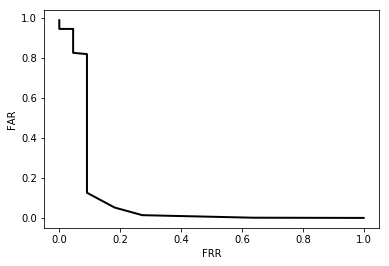

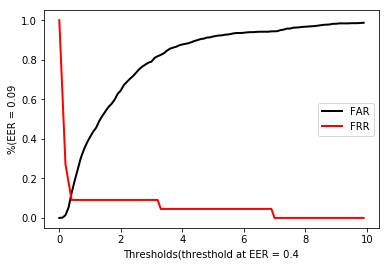

In [17]:
fig = plt.figure()
plt.plot(frr,far,color='black', linewidth=2)
plt.xlabel('FRR')
plt.ylabel('FAR')
fig = plt.figure()
plt.plot(thresholds,far,color='black', linewidth=2,label='FAR')
plt.plot(thresholds,frr,color='red', linewidth=2,label='FRR')
plt.legend(loc='center right')
plt.xlabel('Thresholds(thresthold at EER = '+str(round(threshold_at_eer,2)))
plt.ylabel('%(EER = '+str(round(eer,2)))

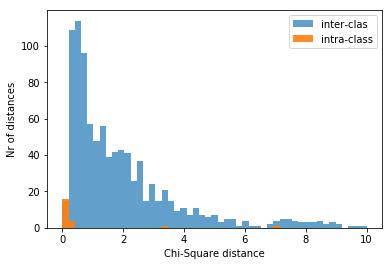

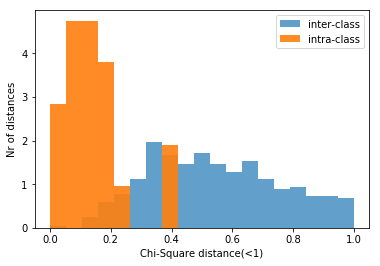

Text(0,0.5,'Recognition Rate')

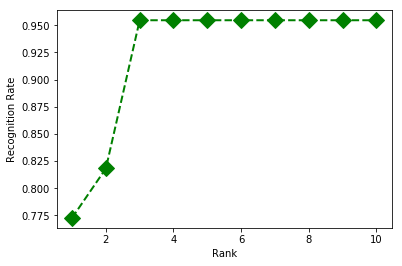

In [26]:
#-------------------------------- histogram of distance -------------------------------
# plt.hist(distance_to_target, bins='auto')  # arguments are passed to np.histogram
bins = np.linspace(0, 10, 50)

# plt.hist(distance_to_target, bins='auto', alpha=0.5, label='distance_to_target')
fig = plt.figure()


plt.hist(distance_to_false.flatten(), bins,alpha = 0.7, label='inter-clas')
plt.hist(distance_to_correct, bins,alpha = 0.9,label='intra-class')

plt.legend(loc='upper right')
plt.xlabel('Chi-Square distance')
plt.ylabel('Nr of distances')
plt.show()

fig = plt.figure()
bin2 = np.linspace(0,1,20)
plt.hist(distance_to_false.flatten(), bin2,density =True, alpha = 0.7,label='inter-class')
plt.hist(distance_to_correct, bin2,density =True, alpha = 0.9,label='intra-class')
plt.legend(loc='upper right')
plt.xlabel('Chi-Square distance(<1)')
plt.ylabel('Nr of distances')
plt.show()

fig = plt.figure()
ranks = np.linspace(1, 10,10, endpoint=True)
plt.plot(ranks,ccr[1:11],color='green', marker='D', linestyle='dashed',linewidth=2, markersize=12)
plt.xlabel('Rank')
plt.ylabel('Recognition Rate')

